In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../")

In [2]:
import pickle as pk
import numpy as np

from steric_free_simulator import Optimizer
from steric_free_simulator import ReactionNetwork

/home/spencerloggia/Projects/biphy/multi_assembly/steric_free_simulator/energy_space_explorer.py:8: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.relax import *


In [ ]:
from steric_free_simulator import EnergyExplorer

Define the AP2 Network from scratch. We will build the one step network.

In [ ]:
base_input = './input_files/ap2.bngl'
rn = ReactionNetwork(base_input, one_step=True)

Create an EnergyExplorer object to define the Rxn Energies on each edge. If relaxed poses are already defined in the subunit dir, will load them instead of recalculating. Otherwise will build all pdb states from monomer pdb files. Raw PDB names must match monomer labels in the reaction network.

In [ ]:
subunit_dir = './pdbs/AP2_subunits'
en = EnergyExplorer(rn, subunit_dir)
en.explore_network()

# Dump the explored network to pickle binary for easy reuse.
unoptimized_save_loc = './local_saves/ap2_en_net_vivo.pkl'
with open(unoptimized_save_loc, 'wb') as f:
    pk.dump(rn, f)

Can skip the above two steps if load existing explore network pickle.


In [18]:
unoptimized_save_loc = './local_saves/ap2_en_net_vivo.pkl'
with open(unoptimized_save_loc, 'rb') as f:
    rn = pk.load(f)

Initialize parameters to equal in the reaction network, and add them to the hash map tracking optimization parameters.

In [19]:
rn.reset()
rn.intialize_activations()
print(rn._initial_copies)

{0: tensor([1516.], dtype=torch.float64), 1: tensor([2066.], dtype=torch.float64), 2: tensor([947.], dtype=torch.float64), 3: tensor([469.], dtype=torch.float64), 4: tensor([0.], dtype=torch.float64), 5: tensor([0.], dtype=torch.float64), 6: tensor([0.], dtype=torch.float64), 7: tensor([0.], dtype=torch.float64), 8: tensor([0.], dtype=torch.float64), 9: tensor([0.], dtype=torch.float64), 10: tensor([0.], dtype=torch.float64), 11: tensor([0.], dtype=torch.float64), 12: tensor([0.], dtype=torch.float64), 13: tensor([0.], dtype=torch.float64), 14: tensor([0.], dtype=torch.float64)}


Create an optimizer object to run many simulations on the energy defined reaction network, tuning association parameters at each iteration.

In [20]:
optim = Optimizer(reaction_network=rn,
                  sim_runtime=.0025,
                  optim_iterations=500,
                  learning_rate=10)
optim.optimize()

yield on sim iteration 0 was 39.8%
param update: tensor([-4.3691,  9.9729, -9.0991,  9.9907,  9.9916,  9.9936,  9.9932, -9.9910,
         9.9914, -9.9835, -9.9367, -9.9928,  9.9887, -9.9832, -9.7766, -9.9888,
        -9.9769, -9.9934, -9.9910,  9.9893,  9.9863, -9.9697,  9.9844, -9.9222,
        -9.9940], dtype=torch.float64)
yield on sim iteration 1 was 40.0%
param update: tensor([5.4010, 9.9771, 7.4414, 9.9900, 9.9907, 9.9933, 9.9945, 7.4414, 9.9929,
        7.4414, 7.4414, 7.4414, 9.9885, 7.4414, 7.4414, 7.4414, 7.4414, 7.4414,
        7.4414, 9.9896, 9.9850, 7.4414, 9.9853, 7.4414, 7.4414],
       dtype=torch.float64)
yield on sim iteration 2 was 40.0%
param update: tensor([7.0606, 9.9785, 5.7522, 9.9897, 9.9903, 9.9935, 9.9954, 5.7522, 9.9942,
        5.7522, 5.7522, 5.7522, 9.9889, 5.7522, 5.7522, 5.7522, 5.7522, 5.7522,
        5.7522, 9.9898, 9.9843, 5.7522, 9.9863, 5.7522, 5.7522],
       dtype=torch.float64)
yield on sim iteration 3 was 40.1%
param update: tensor([7.8302, 9.9

Plot the simulation default observables at first

In [ ]:
with open('./local_saves/optimizer_ap2_vivo_stablerxn.pkl', 'rb') as f:
    optim = pk.load(f)

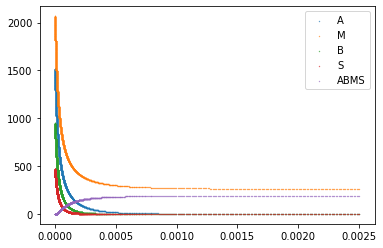

In [21]:
optim.plot_observable(iteration=0)


Plot the simulation default observables after last iteration


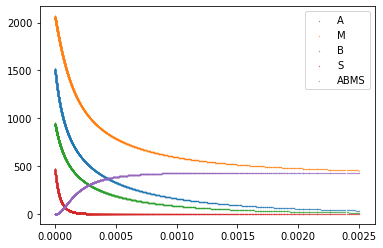

In [22]:
optim.plot_observable(iteration=-1)

Plot the yield curve over iterations

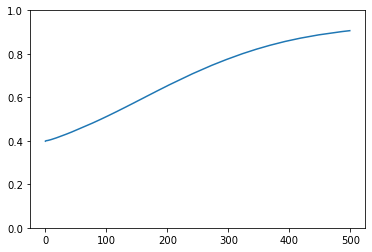

In [23]:
optim.plot_yield()

In [24]:
print(optim.rn.EA)

Parameter containing:
tensor([4389.2569, 5894.6142,   51.4897, 5711.1831, 3749.9627, 2198.1381,
        4319.8277,   50.5893, 5248.2939,   50.5972,   50.6465,   50.5790,
        2729.4727,   50.6038,   50.8107,   50.5981,   50.6098,   50.5933,
          50.5893, 3648.3446, 2381.5262,   50.6176, 2644.4945,   50.6644,
          50.5838], dtype=torch.float64, requires_grad=True)


In [25]:
with open('./local_saves/optimizer_ap2_vivo_stablerxn.pkl', 'wb') as f:
    pk.dump(optim, f)